In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# Q3
## Random forest and one-class SVM for email spam classifier

Your task for this question is to build a spam classifier using the UCR email spam dataset https:
//archive.ics.uci.edu/ml/datasets/Spambase came from the postmaster and individuals who had
filed spam. Please download the data from that website. The collection of non-spam emails came from
filed work and personal emails, and hence the word ’george’ and the area code ’650’ are indicators of
non-spam. These are useful when constructing a personalized spam filter. You are free to choose any
package for this homework. Note: there may be some missing values. You can just fill in zero.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import ParameterGrid
import time

In [3]:
data = pd.read_csv('spambase.data', header=None)
data.fillna(0, inplace=True)

In [4]:
with open('spambase.names', 'r') as fh:
    names = fh.readlines()[33:]
    
names = [x.split(':')[0] for x in names]
names.append('spam')

In [5]:
data.columns = names
data.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [6]:
X = data.iloc[:, :57].values
y = data.iloc[:, 57].values

#### (a) Build a CART model and visualize the fitted classification tree.

In [7]:
cart = DecisionTreeClassifier(max_depth=4)
cart = cart.fit(X,y)

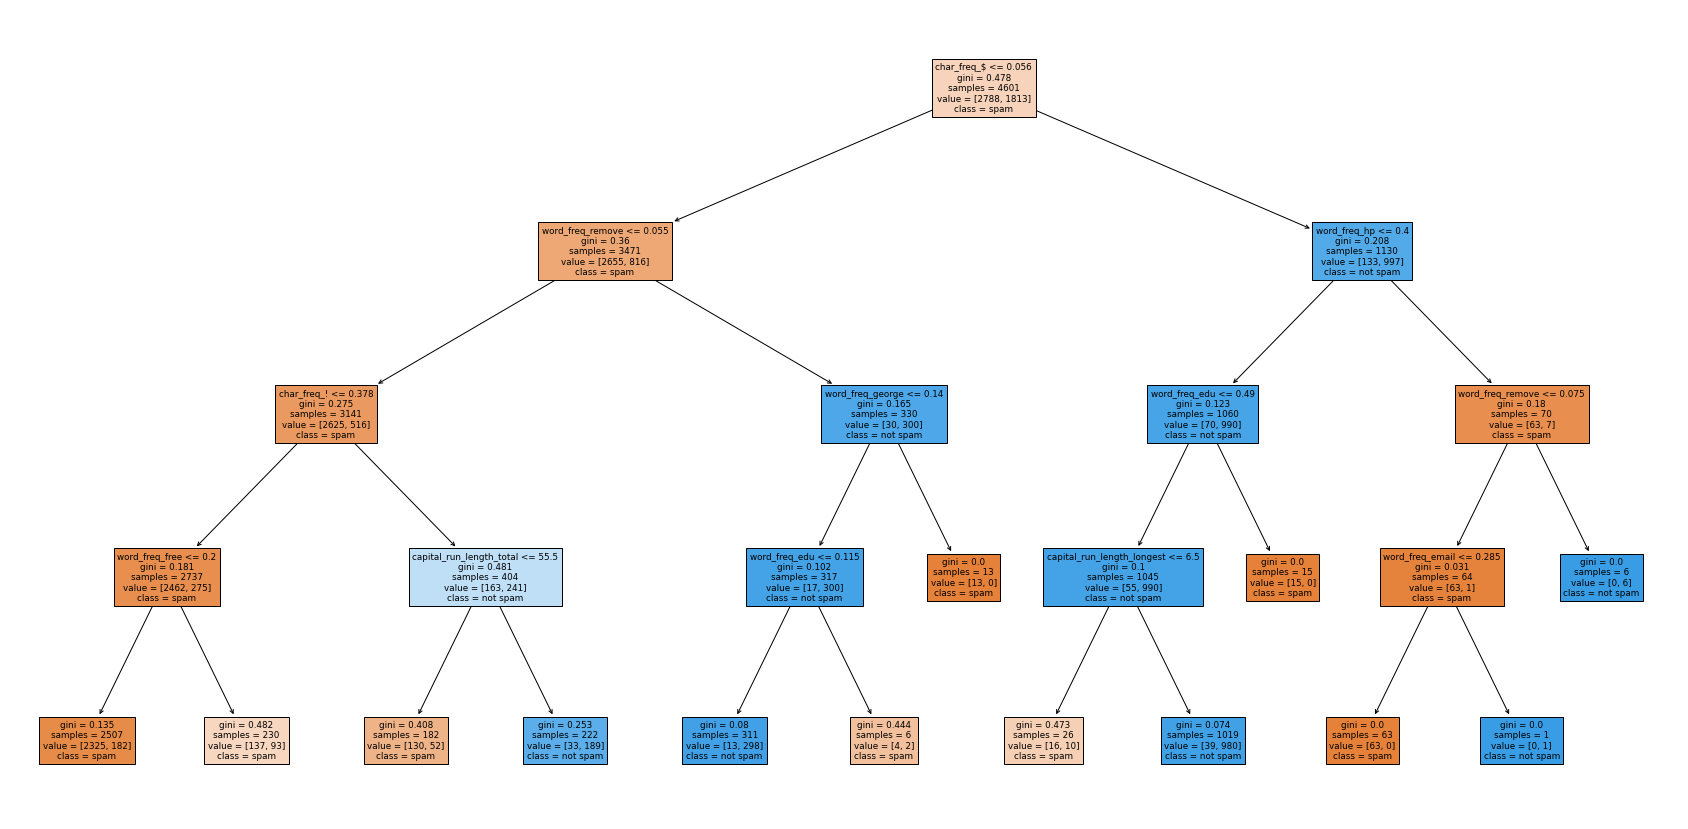

In [8]:
plt.figure(figsize=(30,15))
tree.plot_tree(cart, feature_names=names, class_names=['spam','not spam'], filled=True)
plt.savefig('tree.png', bbox_layout='tight', bbox_inches='tight')
plt.show()

#### (b) Now also build a random forest model. Partition the data to use the first 80% for training and the remaining 20% for testing. Compare and report the test error for your classification tree and random forest models on testing data. Plot the curve of test error (total misclassification error rate) versus the number of trees for the random forest, and plot the test error for the CART model (which should be a constant with respect to the number of trees).

In [9]:
X_train, X_test, y_train, y_test = train_test_split( X,y, test_size=0.2, random_state=42, shuffle=True)

In [10]:
rf_scores = []
cart_scores = []

In [11]:
cart = DecisionTreeClassifier()
cart = cart.fit(X_train, y_train)
acc = accuracy_score(y_test, cart.predict(X_test))
cart_scores.append(1 - acc)

In [12]:
for i in range(1,101):
    rf = RandomForestClassifier(n_estimators = i, n_jobs=-1)
    rf = rf.fit(X_train, y_train)
    
    acc = accuracy_score(y_test, rf.predict(X_test))
    rf_scores.append(1 - acc)

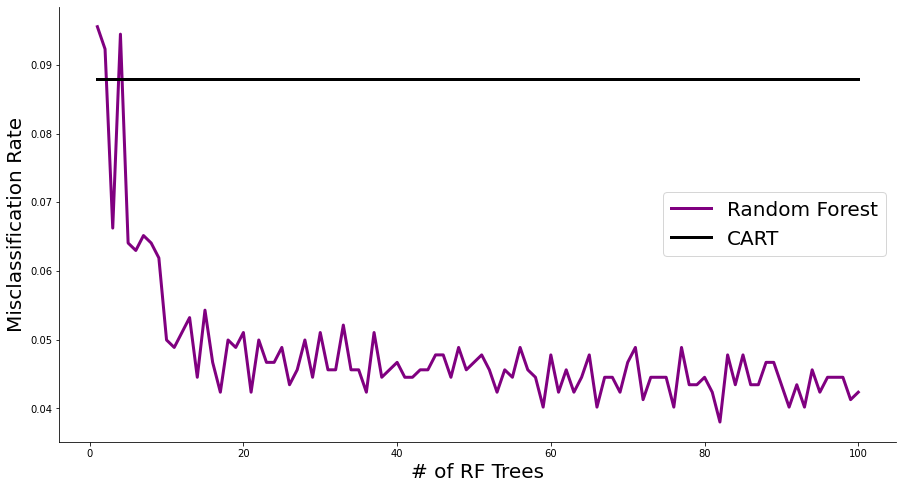

In [13]:
plt.figure(figsize=(15,8))
ax = plt.subplot()
ax.plot(range(1,101), rf_scores, label='Random Forest', lw=3, color='purple')
ax.plot(range(1,101), cart_scores * 100, label='CART', lw=3, color='black')
ax.set_xlabel('# of RF Trees', size=20)
ax.set_ylabel('Misclassification Rate', size=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=20)
plt.savefig('cart_rf.png', bbox_inches='tight', bbox_layout='tight')
plt.show()

#### (c) Now we will use a one-class SVM approach for spam filtering. Partition the data to use the first 80% for training and the remaining 20% for testing. Extract all non-spam emails from the training block (80% of data you have selected) to build the one-class kernel SVM using RBF kernel (you can turn the kernel bandwidth to achieve good performance). Then apply it on the 20% of data reserved for testing (thus this is a novelty detection situation), and report the total misclassification error rate on these testing data.

In [15]:
X_train, X_test, y_train, y_test = train_test_split( X,y, test_size=0.2, random_state=42, shuffle=True)

In [16]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
no_spam_indices = np.argwhere(y_train == 0).ravel()

In [18]:
X_noSpam = X_train[no_spam_indices]

In [38]:
grid = {'gamma' : np.logspace(-15, 15, 10),
        'nu' : np.linspace(0.0001, 0.99, 10)}

In [39]:
preds = []
clf = svm.OneClassSVM(kernel='rbf')
tick = time.time()
for z in ParameterGrid(grid):
    clf.set_params(**z)
    clf.fit(X_noSpam)
    preds.append(clf.predict(X_test))
tock = time.time()

print('Total runtime: {}s'.format(tock-tick))

Total runtime: 34.177419662475586s


In [40]:
for x in preds:
    x[x==1] = 0
    x[x==-1] = 1

In [41]:
np.argmax([accuracy_score(y_test, x) for x in preds])

40

In [42]:
print('best acc: {}'.format(accuracy_score(y_test, preds[40])))
print('best params: {}'.format(ParameterGrid(grid)[40]))

best acc: 0.6199782844733985
best params: {'nu': 0.0001, 'gamma': 0.021544346900318867}
